In [1]:
!nvidia-smi

Fri Jul 10 17:30:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 28%   39C    P0    54W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 29%   41C    P0    62W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model_rev import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
import glob
import cv2

def load_data(phase, cls, les = None, data = 'sm', data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed', 
              extract_name = False, image_ch = 'bgr'):
    """
    phase = 'train', 'test'
    cls: [les]  
      'n': ['neg']
      'h': ['redspot', 'angio', 'active'], 
      'd': ['ero', 'ulc', 'str'],
      'p': ['amp', 'lym', 'tum']}
    """
    lesions = dict(neg = 'negative', 
                   redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                   ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                   amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
    classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

    path = os.path.join(data_dir, data, phase, classes[cls], lesions[les])
    pathlist = glob.glob(path + '/*.jpg')
    new_pathlist = []
    for p in pathlist:
        name = os.path.basename(p)
        name_seg1 = name.split('___')[0]
        if not ('f_' in name_seg1 or 'r1_' in name_seg1 or 'r2_' in name_seg1 or 'r3_' in name_seg1):
            new_pathlist.append(p)
    return load_image_from_path(new_pathlist, image_ch = image_ch, extract_name = extract_name)

def load_image_from_path(pathlist,image_ch = 'bgr', extract_name = False):
    data = []
    for i in pathlist:
        temp = cv2.imread(i)
        if image_ch == 'bgr':
            pass
        elif image_ch == 'rgb':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        elif image_ch == 'hsv':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
        data.append(temp)
    if extract_name != False:
        name = []
        for i in pathlist:
            name.append(os.path.basename(i))
        return np.asarray(data), np.asarray(name)
    else:
        return np.asarray(data) 

In [4]:
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_v2', extract_name = True)

In [5]:
neg_img, neg_name = load_data('test', 'n', 'neg', data = 'sm_v2', extract_name = True)
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm_v2', extract_name = True)
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_v2', extract_name = True)
active_img, active_name = load_data('test', 'h', 'active', data = 'sm_v2', extract_name = True)
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm_v2', extract_name = True)
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm_v2', extract_name = True)
str_img, str_name = load_data('test', 'd', 'str', data = 'sm_v2', extract_name = True)

In [6]:
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (1561, 512, 512, 3) (1561, 2)
red spot: (139, 512, 512, 3) (139, 2)
angioectasia: (5, 512, 512, 3) (5, 2)
active_bleeding: (108, 512, 512, 3) (108, 2)
erosion: (185, 512, 512, 3) (185, 2)
ulcer: (183, 512, 512, 3) (183, 2)
stricture: (26, 512, 512, 3) (26, 2)


In [7]:
len(redspot_name) + len(angio_name) + len(active_name)

252

In [8]:
len(ero_name) + len(ulcer_name) + len(str_name)

394

In [9]:
len(redspot_name) + len(angio_name) + len(active_name) + len(ero_name) + len(ulcer_name) + len(str_name)

646

In [10]:
np.random.choice(len(neg_name), 4522)

array([ 438, 1329,  348, ...,  872, 1272,  469])

In [11]:
neg2_img = neg_img[np.random.choice(len(neg_name), 4522)]
neg2_label = one_hot(neg2_img, 0)

In [12]:
neg2_img.shape

(4522, 512, 512, 3)

# Model Inference

In [13]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'ENTIRE2_NH' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'ENTIRE2_ND' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'ENTIRE2_B' in i])

In [19]:
nh_list

['ENTIRE2_NH_2001060148_2540_val_acc_1.00_val_loss_0.034387',
 'ENTIRE2_NH_2001060150_2870_val_acc_0.98_val_loss_0.027345',
 'ENTIRE2_NH_2001060155_3730_val_acc_1.00_val_loss_0.015424',
 'ENTIRE2_NH_2001060204_5320_val_acc_1.00_val_loss_0.009253',
 'ENTIRE2_NH_2001060208_6000_val_acc_1.00_val_loss_0.005527',
 'ENTIRE2_NH_2001062352_20490_val_acc_1.00_val_loss_0.000032',
 'ENTIRE2_NH_2001070020_23020_val_acc_1.00_val_loss_0.000018',
 'ENTIRE2_NH_2001070150_5800_val_acc_0.98_val_loss_0.043403',
 'ENTIRE2_NH_2001070151_5900_val_acc_0.98_val_loss_0.038373',
 'ENTIRE2_NH_2001070214_8200_val_acc_1.00_val_loss_0.035504',
 'ENTIRE2_NH_2001070221_8900_val_acc_0.99_val_loss_0.023356',
 'ENTIRE2_NH_2001080155_12800_val_acc_0.99_val_loss_0.016635',
 'ENTIRE2_NH_2001081600_2000_val_acc_0.97_val_loss_0.093729',
 'ENTIRE2_NH_2001081601_2100_val_acc_0.97_val_loss_0.057087',
 'ENTIRE2_NH_2001081619_3800_val_acc_0.97_val_loss_0.054612',
 'ENTIRE2_NH_2001081626_4500_val_acc_0.98_val_loss_0.046558',
 'ENT

In [20]:
nd_list

['ENTIRE2_ND_2001062348_20190_val_acc_1.00_val_loss_0.002604',
 'ENTIRE2_ND_2001062355_20780_val_acc_1.00_val_loss_0.001135',
 'ENTIRE2_ND_2001070006_21740_val_acc_1.00_val_loss_0.000432',
 'ENTIRE2_ND_2001070141_4900_val_acc_0.96_val_loss_0.124103',
 'ENTIRE2_ND_2001070150_5800_val_acc_0.96_val_loss_0.120055',
 'ENTIRE2_ND_2001070152_6000_val_acc_0.97_val_loss_0.106324',
 'ENTIRE2_ND_2001070211_7800_val_acc_0.96_val_loss_0.104963',
 'ENTIRE2_ND_2001070212_7900_val_acc_0.97_val_loss_0.058071',
 'ENTIRE2_ND_2001081614_2700_val_acc_0.95_val_loss_0.130868',
 'ENTIRE2_ND_2001081615_2800_val_acc_0.96_val_loss_0.113698',
 'ENTIRE2_ND_2001081634_4700_val_acc_0.95_val_loss_0.104473',
 'ENTIRE2_ND_2001081639_5200_val_acc_0.97_val_loss_0.078812',
 'ENTIRE2_ND_2001081650_6300_val_acc_0.98_val_loss_0.049867',
 'ENTIRE2_ND_2001100010_10_val_acc_0.50_val_loss_0.691652',
 'ENTIRE2_ND_2001100010_50_val_acc_0.48_val_loss_0.690351',
 'ENTIRE2_ND_2001100011_60_val_acc_0.47_val_loss_0.679513',
 'ENTIRE2_N

In [21]:
b_list

['ENTIRE2_B_2001060434_9410_val_acc_1.00_val_loss_0.019657',
 'ENTIRE2_B_2001060441_9870_val_acc_1.00_val_loss_0.011613',
 'ENTIRE2_B_2001060509_11910_val_acc_1.00_val_loss_0.009551',
 'ENTIRE2_B_2001060518_12540_val_acc_1.00_val_loss_0.008383',
 'ENTIRE2_B_2001060534_13690_val_acc_1.00_val_loss_0.006853',
 'ENTIRE2_B_2001081714_6900_val_acc_0.96_val_loss_0.094075',
 'ENTIRE2_B_2001081734_8800_val_acc_0.97_val_loss_0.077247',
 'ENTIRE2_B_2001081739_9300_val_acc_0.98_val_loss_0.059156',
 'ENTIRE2_B_2001081801_11400_val_acc_0.98_val_loss_0.050810',
 'ENTIRE2_B_2001081821_13300_val_acc_0.98_val_loss_0.042233',
 'ENTIRE2_B_2001100012_80_val_acc_0.60_val_loss_0.659025',
 'ENTIRE2_B_2001100013_150_val_acc_0.66_val_loss_0.650705',
 'ENTIRE2_B_2001100013_90_val_acc_0.57_val_loss_0.655705',
 'ENTIRE2_B_2001100014_160_val_acc_0.64_val_loss_0.616498',
 'ENTIRE2_B_2001100014_180_val_acc_0.68_val_loss_0.614124',
 'ENTIRE2_B_2001100015_10_val_acc_0.50_val_loss_0.691157',
 'ENTIRE2_B_2001100015_30_va

In [14]:
nh_path = './model/' + 'NH_2001062207_10900_val_acc_1.00_val_loss_0.000584'
nd_path = './model/' + 'ND_2001060354_8430_val_acc_1.00_val_loss_0.009623'
b_path = './model/' + 'B_2001060534_13690_val_acc_1.00_val_loss_0.006853'

nh_path = './model/' + 'NH_2001080155_12800_val_acc_0.99_val_loss_0.016635'
nd_path = './model/' + 'ND_2001070006_21740_val_acc_1.00_val_loss_0.000432'
b_path = './model/' + 'B_2001080202_18300_val_acc_0.99_val_loss_0.026502'

nh_path = './model/resnet/' + 'NH_2007071254_38700_val_acc_0.99_val_loss_0.023783'
nd_path = './model/resnet/' + 'ND_2007071203_27400_val_acc_0.99_val_loss_0.036596'
b_path = './model/resnet/' + 'B_2007071629_36200_val_acc_0.99_val_loss_0.032725'

# nh_path = './model/' + nh_list[-1]
# nd_path = './model/' + nd_list[-1]
# b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0710 17:30:32.744864 140287753737984 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [15]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

1561 / Inference Time: 00:00:38
139 / Inference Time: 00:00:04
5 / Inference Time: 00:00:01
108 / Inference Time: 00:00:03
185 / Inference Time: 00:00:04
183 / Inference Time: 00:00:04
26 / Inference Time: 00:00:01


In [16]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

1561 / Inference Time: 00:00:17
139 / Inference Time: 00:00:01
5 / Inference Time: 00:00:00
108 / Inference Time: 00:00:01
185 / Inference Time: 00:00:02
183 / Inference Time: 00:00:02
26 / Inference Time: 00:00:00


# Evaluation

In [17]:
cls = classification_metric()

## Accuracy per lesion

In [18]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output, 'neg')
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output, 'red spot')
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output, 'angio')
active_nh_acc = cls.accuracy(active_label, active_nh_output, 'active')

neg: 96.73 %
red spot: 86.33 %
angio: 100.00 %
active: 100.00 %


In [19]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output, 'neg')
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output, 'ero')
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output, 'ulcer')
str_nd_acc = cls.accuracy(str_label, str_nd_output, 'str')

neg: 96.93 %
ero: 91.89 %
ulcer: 94.54 %
str: 92.31 %


In [20]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output, 'neg')
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output, 'red')
angio_b_acc = cls.accuracy(angio_label, angio_b_output, 'ang')
active_b_acc = cls.accuracy(active_label, active_b_output, 'active')
ero_b_acc = cls.accuracy(ero_label, ero_b_output, 'ero')
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output, 'ulcer')
str_b_acc = cls.accuracy(str_label, str_b_output, ' str')

neg: 97.63 %
red: 82.01 %
ang: 100.00 %
active: 97.22 %
ero: 94.05 %
ulcer: 88.52 %
 str: 88.46 %


In [21]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output, 'neg')
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output, 'red')
angio_e_acc = cls.accuracy(angio_label, angio_e_output, 'ang')
active_e_acc = cls.accuracy(active_label, active_e_output, 'active')
ero_e_acc = cls.accuracy(ero_label, ero_e_output, 'ero')
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output, 'ulcer')
str_e_acc = cls.accuracy(str_label, str_e_output, 'str')

neg: 94.30 %
red: 87.77 %
ang: 100.00 %
active: 100.00 %
ero: 95.68 %
ulcer: 97.27 %
str: 96.15 %


## Confusion Matrix

In [22]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

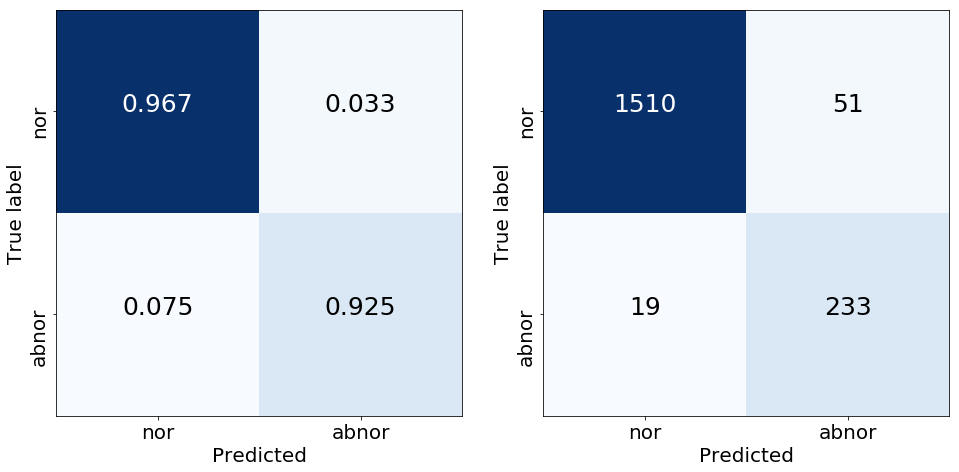

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [24]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

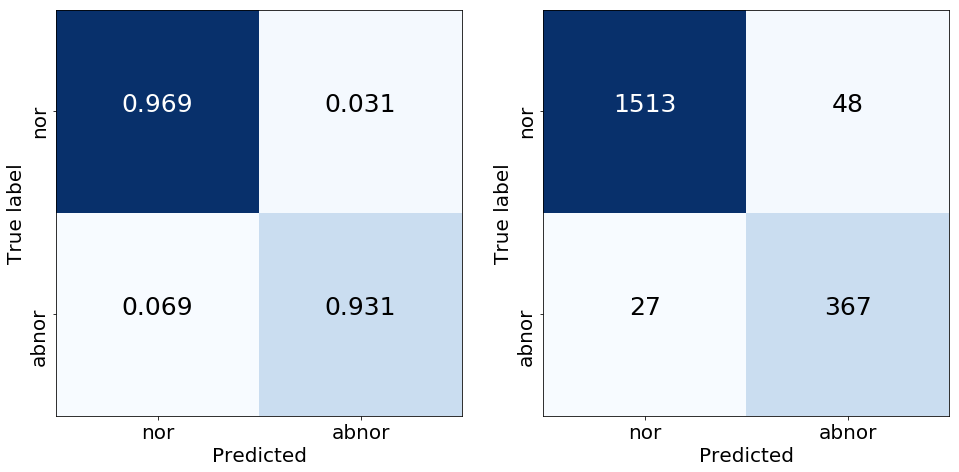

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [26]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

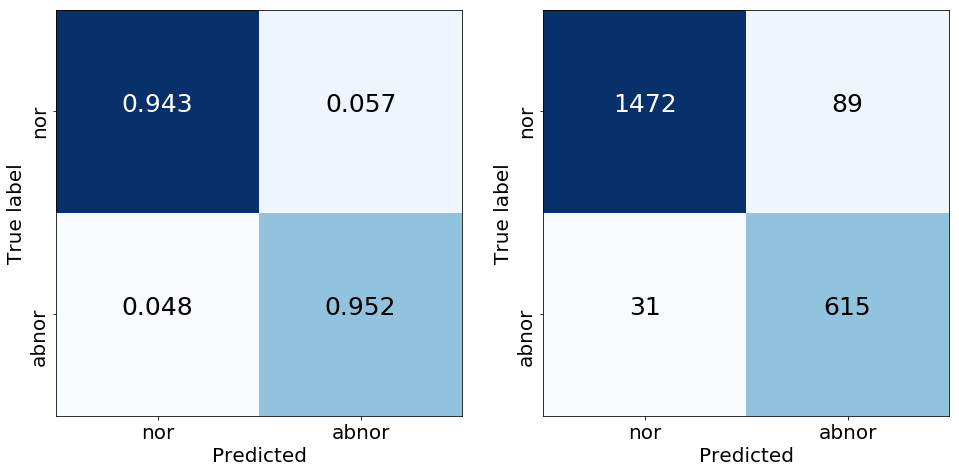

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [28]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

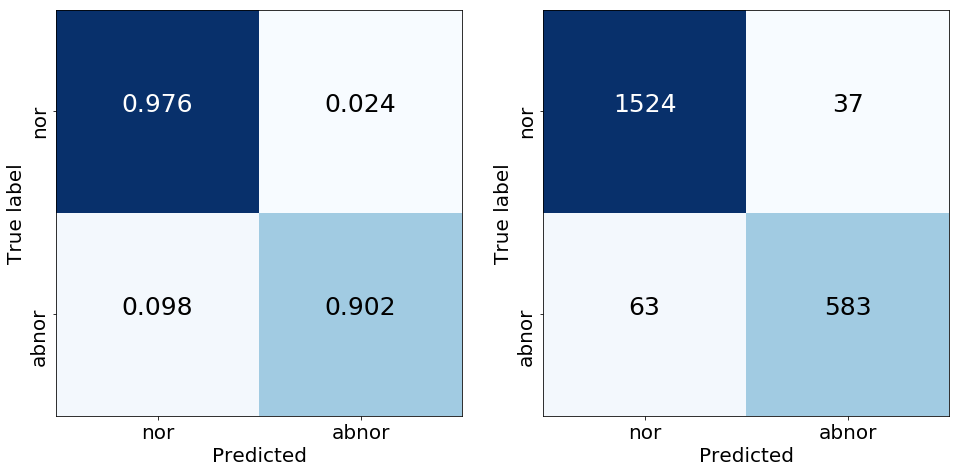

In [29]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [30]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [31]:
from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [32]:
n_g = 5

_, neg2_idxs = k_fold_idx(n_fold = n_g, dataset = neg2_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

In [37]:
neg2_b_output = model_prob(B_model, neg2_img)

4522 / Inference Time: 00:00:49


KeyboardInterrupt: 

In [46]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])

    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])

    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

    b_aucs.append(auc(b_fpr, b_tpr))

In [47]:
 b_aucs

[0.995858462317068,
 0.9835189120271993,
 0.9941712049012934,
 0.9827157079646018,
 0.9753588600097555]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


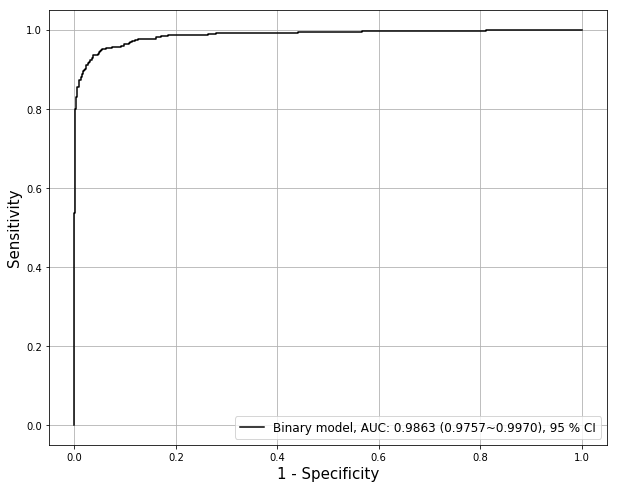

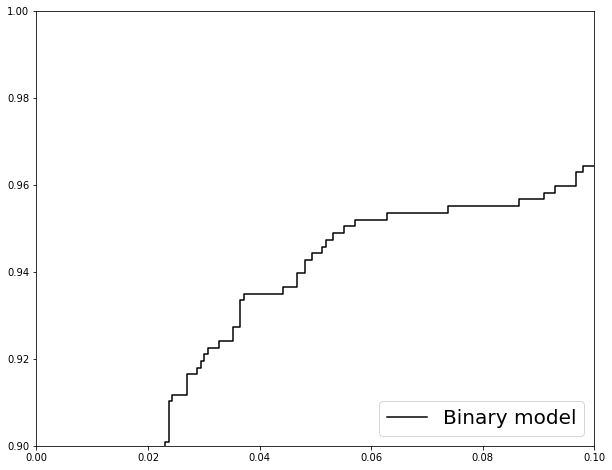

In [48]:

b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])

labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])


b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

In [50]:
b_fpr.shape

(170,)

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [36]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(1036, 2)
(1035, 2)
(1034, 2)
(1032, 2)
(1031, 2)


In [37]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [38]:
b_metrices

array([[0.96911197, 0.92366412, 0.97569061, 0.98880179, 0.84615385],
       [0.95845411, 0.88461538, 0.96906077, 0.98318386, 0.8041958 ],
       [0.96615087, 0.88461538, 0.97787611, 0.98331479, 0.85185185],
       [0.96705426, 0.921875  , 0.97345133, 0.98876404, 0.83098592],
       [0.96702231, 0.8976378 , 0.97676991, 0.98549107, 0.84444444]])

In [39]:
e_metrices

array([[0.94401544, 0.96183206, 0.94143646, 0.99416569, 0.70391061],
       [0.94009662, 0.96153846, 0.93701657, 0.99413834, 0.68681319],
       [0.94294004, 0.92307692, 0.94579646, 0.98843931, 0.71005917],
       [0.94573643, 0.9453125 , 0.94579646, 0.99187935, 0.71176471],
       [0.9456838 , 0.96850394, 0.94247788, 0.9953271 , 0.70285714]])

In [40]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 96.56 (96.04 ~ 97.07)
Sen --- 90.25 (87.85 ~ 92.64)
Spec --- 97.46 (97.02 ~ 97.89)
NPV --- 98.59 (98.25 ~ 98.94)
PPV --- 83.55 (81.18 ~ 85.93)

Ensemble model
Accr --- 94.37 (94.08 ~ 94.66)
Sen --- 95.21 (92.93 ~ 97.48)
Spec --- 94.25 (93.80 ~ 94.70)
NPV --- 99.28 (98.94 ~ 99.62)
PPV --- 70.31 (69.08 ~ 71.53)


### Equal-Variance Test

In [41]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 1.093, pvalue=0.295732078663
bartlett test for sensitivity: 0.009, pvalue=0.922723857021
bartlett test for specificity: 0.006, pvalue=0.936280527511
bartlett test for negative predictive values: 0.001, pvalue=0.976595110253
bartlett test for positive predictive values: 1.452, pvalue=0.228135724654


In [42]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.135, pvalue=0.723213134107
levene test for sensitivity: 0.113, pvalue=0.745637746774
levene test for specificity: 0.018, pvalue=0.895298678462
levene test for negative predictive values: 0.098, pvalue=0.762814540535
levene test for positive predictive values: 0.599, pvalue=0.461101767426


### Normality Test

In [43]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 1.000, pvalue=0.007936507937
Kolmogorov-Smirnov test for sensitivity: 0.800, pvalue=0.079365079365
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.007936507937
Kolmogorov-Smirnov test for negative predictive values: 0.800, pvalue=0.079365079365
Kolmogorov-Smirnov test for positive predictive values: 1.000, pvalue=0.007936507937


### Wilcoxon signed-ranks test (not normal and paired group)

In [44]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.043114446783
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.043114446783
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.043114446783
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.043114446783
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.043114446783


/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Paired two-sample t-Test (normal and paired group)

In [45]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: 19.504, pvalue=0.000040745371
t-statistics for sensitivity: -4.794, pvalue=0.008683333524
t-statistics for specificity: 26.536, pvalue=0.000011986457
t-statistics for negative predictive values: -4.591, pvalue=0.010096348696
t-statistics for positive predictive values: 22.905, pvalue=0.000021523899


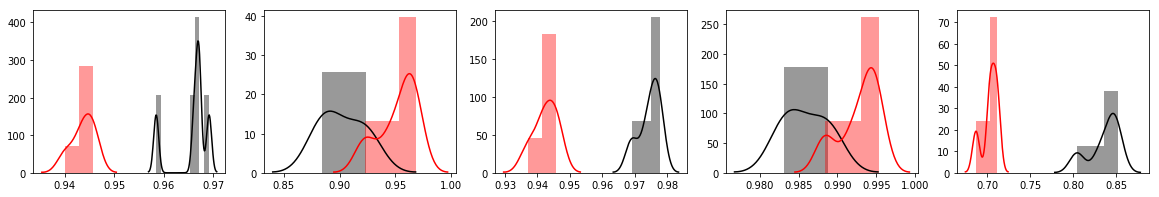

In [46]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()